In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from astroNN.nn.layers import MCDropout

In [2]:
model = tf.keras.models.load_model('../arxiv_models/FFNN_Hz.h5')
ffnn_do = tf.keras.models.load_model('../arxiv_models/FFNN+MC-DO_Hz.h5', custom_objects={'MCDropout': MCDropout})

In [3]:
file = '../data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
z = data.values[:,0]
y = data.values[:,1:]
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
# z = scalerz.transform(z.reshape(-1,1))

StandardScaler()

## First, we predict at the same redshifts than within the original dataset.

In [4]:
r = scalerz.transform(z.reshape(-1, 1))
predh = model.predict(r)

In [5]:
# save fake data
mockHz_ffnn = np.concatenate((z.reshape(len(z), 1), predh), axis=1)
# np.savetxt("Hz_ffnn_mock.dat",mockHz_ffnn, delimiter=" ")

(0.0, 2.065)

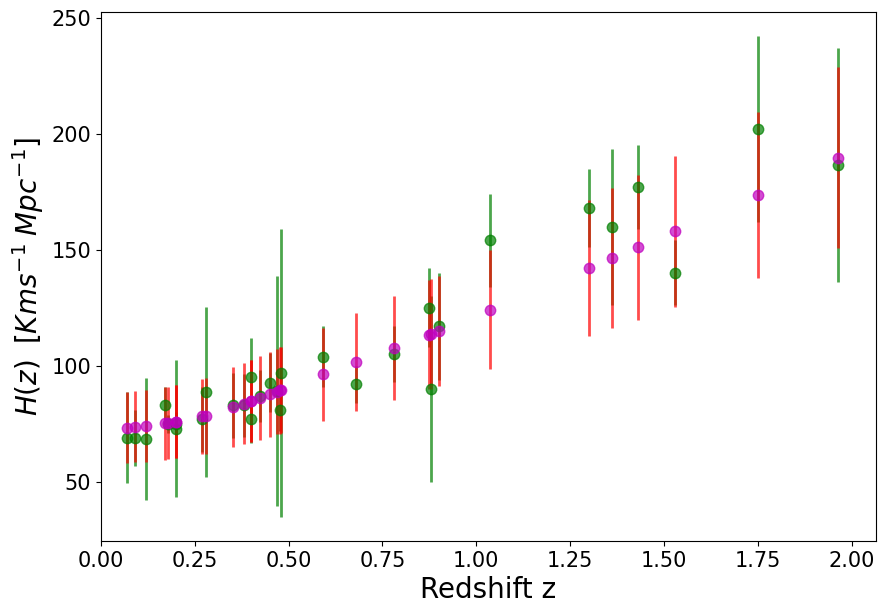

In [6]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.7, elinewidth=2)
plt.errorbar(z, predh[:,0], predh[:,1], markersize=15, fmt='.', 
             ecolor='r', capthick=2, elinewidth=2, alpha=0.7, c='m')

plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.text( 0.1, 280, "$MSE_{val} =  634.5$", fontsize=20 )
# plt.text( 0.1, 240, "$\Delta MSE_{val} = 54.0$", fontsize=20 )
plt.ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
plt.xlim(0, max(z)+0.1)

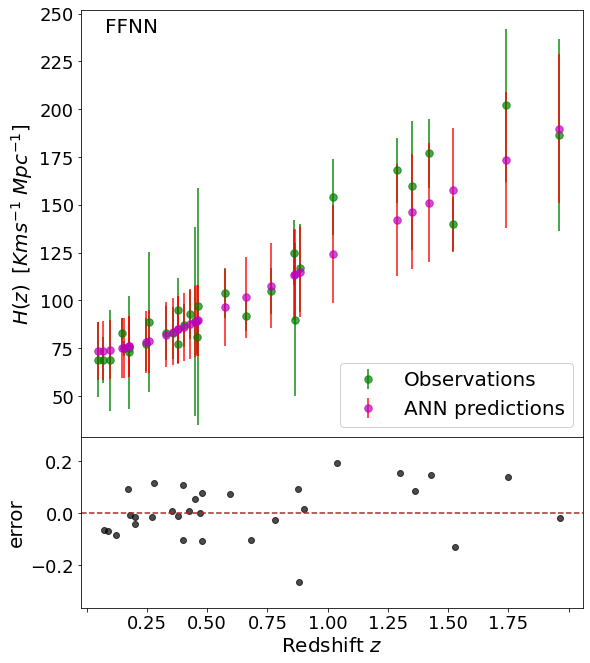

In [7]:
fig, axs = plt.subplots(2,1,figsize=(9, 11), gridspec_kw={'height_ratios': [5, 2]})

# axs[0].figure(figsize=(10, 7), dpi=100)
axs[0].errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.7, elinewidth=2)
axs[0].errorbar(z, predh[:,0], predh[:,1], markersize=15, fmt='.', 
                ecolor='r', capthick=2, elinewidth=2, alpha=0.7, c='m', 
                label='ANN predictions')


axs[0].text(0.1, 240, 'FFNN', fontsize=20)
axs[0].legend(fontsize=20, loc='lower right', framealpha=0.9, ncol=1)
axs[0].set_xticks([])

axs[0].set_ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
axs[0].set_xlim(0, max(z)+0.1)
axs[0].set_ylim(min(y[:,0])-40, max(y[:,0])+50)


hdiff = np.subtract(y[:,0], predh[:,0].reshape(31,))
herrdiff = np.subtract(y[:,1], predh[:,1])

# axs[1].errorbar(z, 100*(hdiff/y[:,0]), yerr=herrdiff, c='black',  fmt='o',
#                 ecolor='blue', capthick=2, elinewidth=2, alpha=0.7)
axs[1].scatter(z, hdiff/y[:,0], c='black',  marker='o',alpha=0.7)
# axs[1].plot(z, 100*(hdiff/y[:,0]), c='blue', alpha=0.7)
# axs[1].set_ylabel(r"$\frac{H(z)_{obs} - H(z)_{ANN}}{H(z)_{obs}}$", fontsize=14)
axs[1].set_ylabel("error", fontsize=20)

axs[1].axhline(0, linestyle='--', color='brown')
ylim1 = min(hdiff/y[:,0])-0.1
ylim2 = max(hdiff/y[:,0])+0.1
axs[1].set_ylim(ylim1, ylim2)

axs[1].tick_params(axis='both', which='major', labelsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=18)

x_ticks = axs[1].xaxis.get_major_ticks()
x_ticks[1].label1.set_visible(False)
x_ticks[9].label1.set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0) 

plt.xlabel('Redshift $z$', fontsize=20)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig('hzsameredshifts_ffnn.png', dpi=100)

In [8]:
test_batch_size = len(z)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = ffnn_do.predict(scalerz.transform(z.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


In [9]:
# save fake data
mocky_mcdo = np.concatenate((prediction_mc_dropout[:,0].reshape(-1,1), sigma.reshape(-1,1)), axis=1)
mockHz_ffnn_mcdo = np.concatenate((z.reshape(-1,1), mocky_mcdo), axis=1)
np.savetxt("Hz_mcdo_mock.dat",mockHz_ffnn_mcdo, delimiter=" ")

(0.0, 2.065)

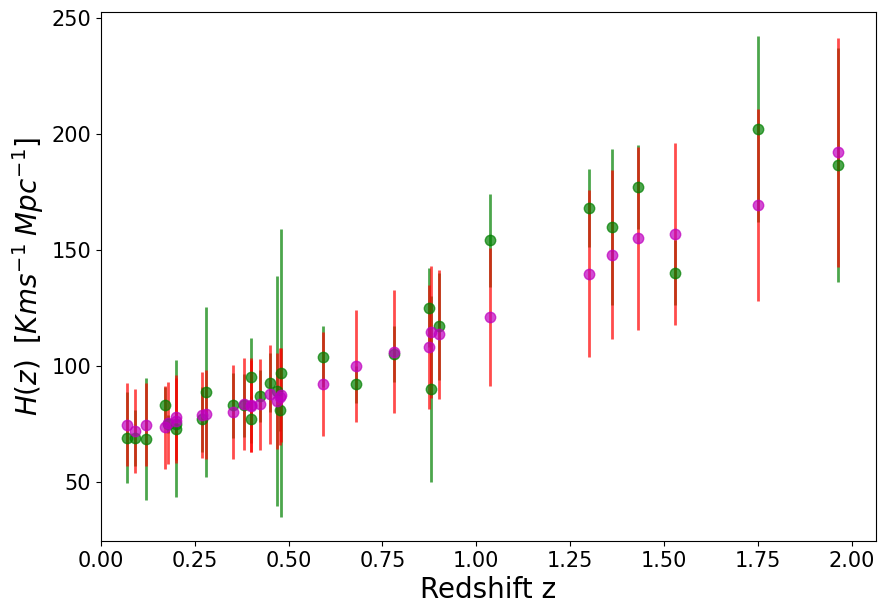

In [10]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.7, elinewidth=2)

# plt.errorbar(z, pred_random[:,0], pred_random[:,1], markersize=15, fmt='.', 
#              ecolor='r', capthick=2, elinewidth=2, alpha=0.5, c='m')

plt.errorbar(z, prediction_mc_dropout[:,0], yerr=sigma, markersize=15, fmt='.', 
             ecolor='r', capthick=2, elinewidth=2, alpha=0.7, c='m',
             label='Synthetic data with $\sigma$')
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.text( 0.1, 280, "$MSE_{val} =  634.5$", fontsize=20 )
# plt.text( 0.1, 240, "$\Delta MSE_{val} = 54.0$", fontsize=20 )
plt.ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
plt.xlim(0, max(z)+0.1)


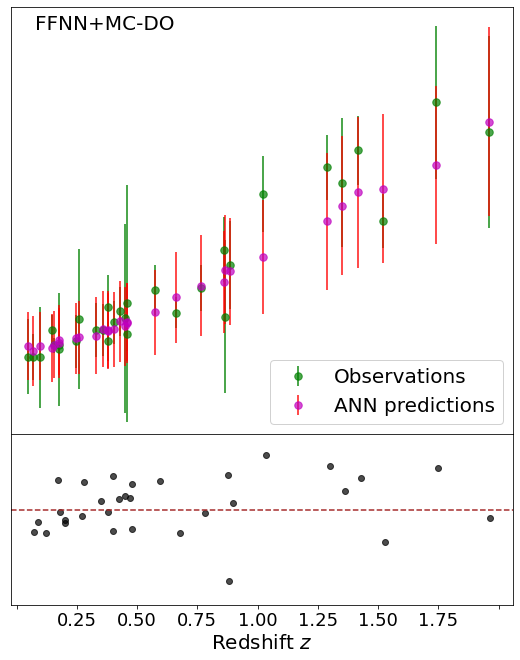

In [11]:
fig, axs = plt.subplots(2,1,figsize=(9, 11), gridspec_kw={'height_ratios': [5, 2]})

# axs[0].figure(figsize=(10, 7), dpi=100)
axs[0].errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.7, elinewidth=2)
axs[0].errorbar(z, prediction_mc_dropout[:,0], yerr=sigma, markersize=15, fmt='.', label='ANN predictions',
                 ecolor='r', capthick=2, elinewidth=2, alpha=0.7, c='m')


axs[0].text(0.1, 240, 'FFNN+MC-DO', fontsize=20)
axs[0].legend(fontsize=20, loc='lower right', framealpha=0.9, ncol=1)
axs[0].set_xticks([])
axs[0].set_yticks([])

# axs[0].set_ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
axs[0].set_xlim(0, max(z)+0.1)
axs[0].set_ylim(min(y[:,0])-40, max(y[:,0])+50)

hdiff = np.subtract(y[:,0], prediction_mc_dropout[:,0].reshape(31,))
herrdiff = np.subtract(y[:,1], sigma)

# axs[1].errorbar(z, 100*(hdiff/y[:,0]), yerr=herrdiff, c='black',  fmt='o',
#                 ecolor='blue', capthick=2, elinewidth=2, alpha=0.7)
axs[1].scatter(z, hdiff/y[:,0], c='black',  marker='o', alpha=0.7)
# axs[1].plot(z, 100*(hdiff/y[:,0]), c='blue',  alpha=0.7)
# axs[1].set_ylabel(r"$\frac{H(z)_{obs} - H(z)_{FFNN+MCDO}}{H(z)_{obs}}$", fontsize=14)
# axs[1].set_ylabel("error", fontsize=20)
axs[1].axhline(0, linestyle='--', color='brown')
axs[1].set_yticks([])
axs[1].set_ylim(ylim1, ylim2)

axs[1].tick_params(axis='both', which='major', labelsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=18)
x_ticks = axs[1].xaxis.get_major_ticks()
x_ticks[1].label1.set_visible(False)
x_ticks[9].label1.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0) 

plt.xlabel('Redshift $z$', fontsize=20)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.savefig('hzsameredshifts_mcdo.png', dpi=100)

## Now, we are going to predict more interpolated points to display a nice $H(z)$ reconstruction

In [37]:
ranz = np.linspace(0, 2.2, 1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))

(0.0, 2.065)

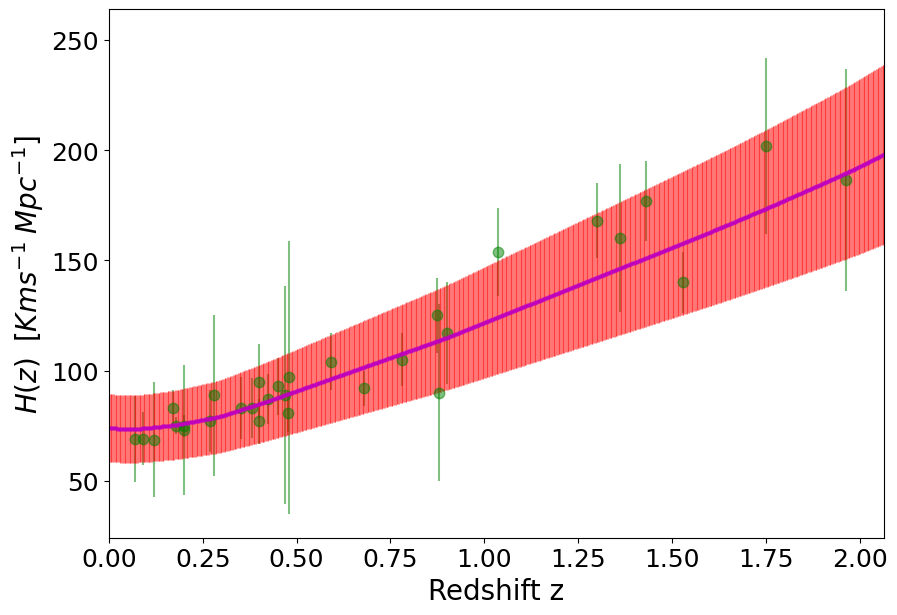

In [38]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(ranz, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m')
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.text( 0.1, 280, "$MSE_{val} =  634.5$", fontsize=20 )
# plt.text( 0.1, 240, "$\Delta MSE_{val} = 54.0$", fontsize=20 )
plt.ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
plt.xlim(0, max(z)+0.1)

### With Om for LCDM

In [39]:
def Hlcdm(z, H0=73.24, Om = 0.27):
    return H0 * np.sqrt(Om*(1+z)**3 + (1 - Om))

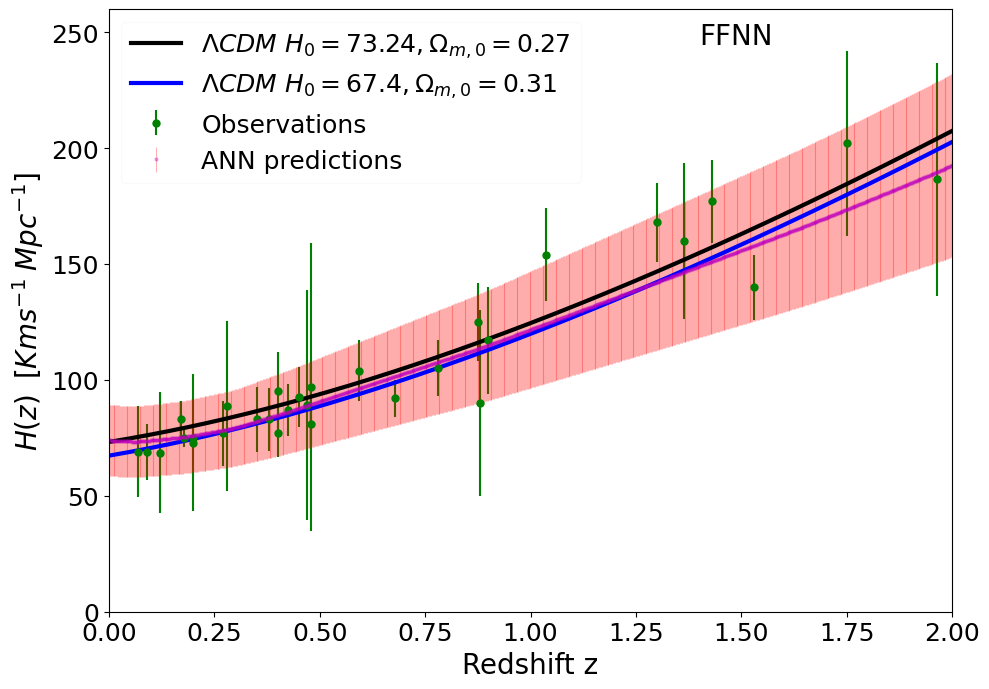

In [40]:
plt.figure(figsize=(10, 7), dpi=100)

zmodel = np.linspace(0, 2, 1000)
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)
plt.errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')

plt.errorbar(ranz, pred_random[:,0], pred_random[:,1], markersize=2., fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='ANN predictions')

plt.plot(zmodel, Hlcdm(zmodel, H0=73.24, Om = 0.27), label='$\Lambda CDM$ $H_0 = 73.24, \Omega_{m,0}=0.27$', c='k', linewidth=3)
plt.plot(zmodel, Hlcdm(zmodel, H0=67.32, Om=0.31), label='$\Lambda CDM$ $H_0 = 67.4, \Omega_{m,0}=0.31$', c='b', linewidth=3)
plt.text(1.4, 245, 'FFNN', fontsize=20)

plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
plt.yticks(fontsize=18)
plt.xlim(0, 2)
plt.ylim(0, 260)
plt.tight_layout()
legend = plt.legend(loc='upper left', fontsize=18)
legend.get_frame().set_alpha(0.1)


plt.savefig('recHZ.png')

In [44]:
test_batch_size = len(r)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = ffnn_do.predict(r)
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

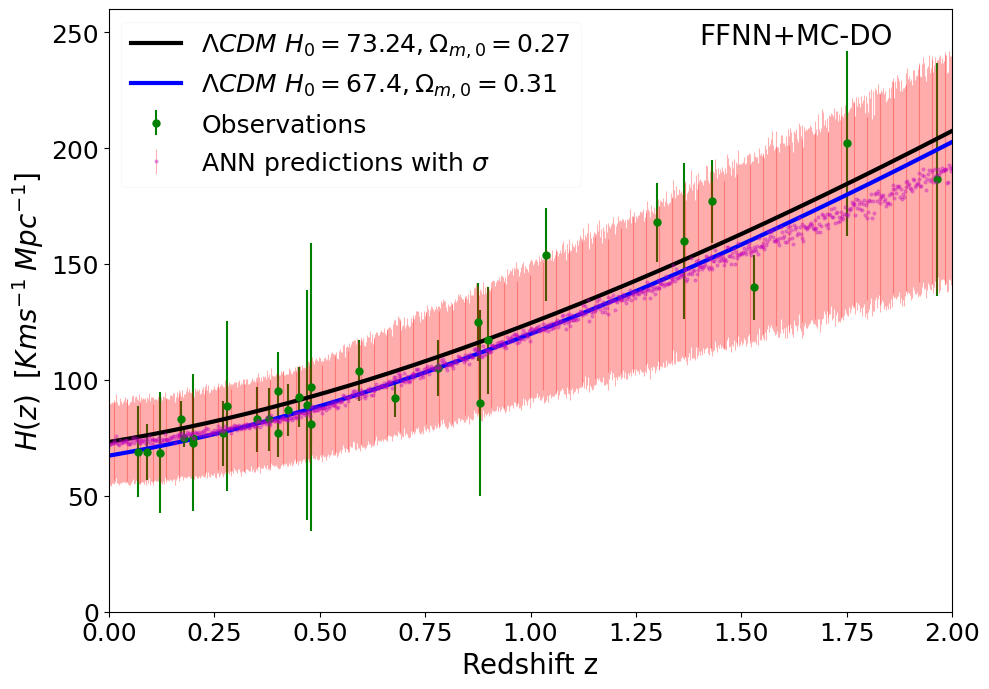

In [46]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='ANN predictions with $\sigma$')
plt.plot(zmodel, Hlcdm(zmodel, H0=73.24, Om = 0.27), label='$\Lambda CDM$ $H_0 = 73.24, \Omega_{m,0}=0.27$', c='k', linewidth=3)
plt.plot(zmodel, Hlcdm(zmodel, H0=67.32, Om=0.31), label='$\Lambda CDM$ $H_0 = 67.4, \Omega_{m,0}=0.31$', c='b', linewidth=3)
plt.xlim(0,2)
plt.ylim(0, 260)
# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.text(1.4, 245, 'FFNN+MC-DO', fontsize=20)
plt.ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.legend(loc='best')
legend = plt.legend(loc='upper left', fontsize=18)
legend.get_frame().set_alpha(0.1)
# plt.show()
plt.tight_layout()

plt.savefig('recHZDOl_new.png')